In [46]:
import splitfolders
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset

In [2]:
# import os
# import pandas as pd

# OUTPUT_DIR = "./smu_no_logo_jpg/"
# img_data = {}

# for folder in os.listdir(OUTPUT_DIR):
#     subfolder_path = os.path.join(OUTPUT_DIR, folder)
#     if os.path.isdir(subfolder_path):  # Check if it's a directory
#         img_data[folder] = {}
#         for subfolder in os.listdir(subfolder_path):
#             subfolder_full_path = os.path.join(subfolder_path, subfolder)
#             if os.path.isdir(subfolder_full_path):  # Check if it's a directory
#                 img_data[folder][subfolder] = len(os.listdir(subfolder_full_path))

# df = pd.DataFrame.from_dict(img_data, orient='index')
# df.T.plot(kind='bar')

In [62]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Assume your data is organized in this structure:
# smu_no_logo_jpg/
#    class1/
#        img1.jpg
#        img2.jpg
#        ...
#    class2/
#        img1.jpg
#        img2.jpg
#        ...

OUTPUT_DIR = "./smu_no_logo_jpg/"

# Image transformations
im_size = 224
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(im_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load the dataset from the directory
full_dataset = datasets.ImageFolder(OUTPUT_DIR, transform=transformation)

# Split the dataset into train, validation, and test sets
# Define your split sizes here
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - (train_size + val_size)

# Use random_split for splitting the dataset
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Creating data loaders for each split
BATCH_SIZE = 20
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Now you can use train_loader, val_loader, and test_loader for your training, validation, and testing loops


In [63]:
image_transforms = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomGrayscale(0.5),
        transforms.RandomAdjustSharpness(0.5),
        transforms.ColorJitter(0.4, 0.4, 0.4),
        transforms.GaussianBlur(3),
        transforms.ToTensor()
    ]
)

In [65]:
train_data

In [69]:
for folder, path_list in train_data:
    if path_list < max_num_img:
        sets = (max_num_img-len(path_list)) // len(path_list)
        mod = (max_num_img-len(path_list)) % len(path_list)
        for i, path in enumerate(path_list):
            img = Image.open(path)
            img = img.convert('RGB')
            sets_iter = sets + 1 if i < mod else sets
            for k in range(sets_iter):
                save_image(image_transforms(img), f'{OUTPUT_DIR}/train/{folder}/augmented_{i}_{k}.jpg')

NameError: name 'max_num_img' is not defined

In [61]:
train_data = {}

for folder in os.listdir(OUTPUT_DIR+'train/'):
    img_path = OUTPUT_DIR+'train/' + folder + '/'
    train_data[folder] = [img_path + img for img in os.listdir(img_path)]

max_num_img = max([len(v) for k,v in train_data.items()])
print(f"Number of images in largest class: {max_num_img}")

FileNotFoundError: [Errno 2] No such file or directory: './smu_no_logo_jpg/train/'

In [50]:
def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [58]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=1):
    plot_training = []
    plot_validation = []

    for e in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(train_loader):
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate performance of each epoch
        model.eval()

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            validation_loss, accuracy = validation(model, criterion, val_loader)

        print(
            "Epoch: {}/{}.. ".format(e + 1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss),
            "Validation Loss: {:.3f}.. ".format(
                validation_loss / len(val_loader)
            ),
            "Validation Accuracy: {:.3f}".format(accuracy / len(val_loader)),
        )

        plot_training.append(running_loss)
        plot_validation.append(validation_loss / len(val_loader))
    
    plt.plot(range(len(plot_training)), plot_training, label='training')
    plt.plot(range(len(plot_validation)), plot_validation, label='validation')
    plt.legend()
    plt.show()

    return model

In [52]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"./checkpoint/{timestamp}_{arch}.pt")

In [53]:
# Assuming full_dataset is your ImageFolder dataset
class_mapping = full_dataset.class_to_idx

In [54]:
model = models.resnet50(weights=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False

In [56]:
print("Original final layer")
print(model.fc)

# Build custom classifier
num_classes = 13
num_ftrs = model.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
model.fc = classifier

print("\nModified final layer")
print(model.fc)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer
Sequential(
  (fc): Linear(in_features=2048, out_features=13, bias=True)
  (output): LogSoftmax(dim=1)
)


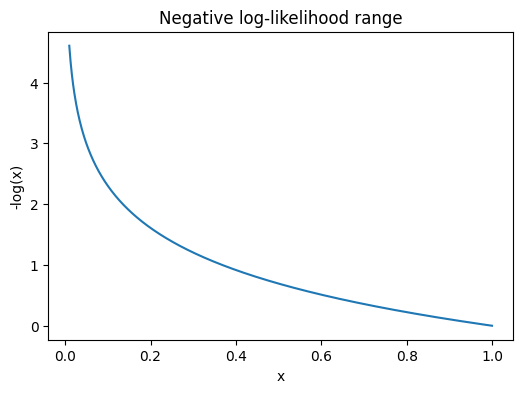

In [57]:
x = np.arange(0.01, 1.0, 0.001)
y = -np.log(x)

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(x,y)
plt.ylabel('-log(x)')
plt.xlabel('x')
plt.title('Negative log-likelihood range')
plt.show()

In [59]:
# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [60]:
# Train model
resnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [19]:
save_checkpoint(resnet_model, class_mapping, 'resnet50')

In [44]:
class_mapping = {value: key for key, value in class_mapping.items()}

print(class_mapping)

{0: 'CIS', 1: 'SOL', 2: 'admin_bldg', 3: 'concourse', 4: 'connex', 5: 'exterior', 6: 'fishtanks', 7: 'inside_sr', 8: 'interior', 9: 'kgc', 10: 'koufu', 11: 'lks', 12: 'non_smu'}


In [29]:
import torch
from torchvision import transforms
from PIL import Image

# Load the model
# model = torch.load('./checkpoint/20240320_resnet50.pt')
checkpoint = torch.load('./checkpoint/20240320_resnet50.pt')
resnet_model.load_state_dict(checkpoint['model_state_dict'])
resnet_model.eval()  # Set the model to evaluation mode

# Define the same transformations as used during training
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and transform the image
img = Image.open('/Users/nicoletan/Documents/SMU/Y2S2/CS424/project/classifier/smu_no_logo_jpg/lks/img_3854.jpg').convert('RGB')
img_t = transform(img)
batch_t = img_t.unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():  # No need to track gradients
    output = resnet_model(batch_t)

# Assuming the model outputs raw scores, which are often the case for classification models
predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
predicted_index = predicted_probabilities.argmax(1).item()

# Load your class mapping
# class_mapping = {0: 'class_name_1', 1: 'class_name_2', ...}  # Update this based on your classes

# Map the predicted index to a class
predicted_class = class_mapping[predicted_index]
print(f'Predicted class: {predicted_class} with confidence {predicted_probabilities.max().item():.2f}')
if predicted_class != "non_smu":
    print("smu")


Predicted class: lks with confidence 0.94
